In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import h5py
import os

from synsets import load_syn_data, det_clsloc_names
from val_data import load_val_database, ValImage, ObjectAnnotation
from data_loader import ValDataLoader
from val_utils import get_db_image

from model_data import *

import cv2

import graphviz

from bounding_boxes import *
from tabulate import tabulate

In [3]:
results = "../results/"
bb_folder = "../bounding_boxes/"
# Load databases
syn_data = load_syn_data()
db = load_val_database(syn_data)
models = load_model_results(syn_data, db)

Loaded DET data
Loaded CLSLOC data
Computed relation between CLSLOC and DET.
Loading Keras imagenet class index
Loading validation data...
Data loaded! 20121 images
Finding val images with only one object..
One object database built: 7706 images
Loading ground truth labels...
Loaded!
Computing image distribution in each of the 200 categories...
Done!
Processing model resnet50
DONE! Processing model resnet50
Processing model inceptionv3
DONE! Processing model inceptionv3
Processing model vgg16
DONE! Processing model vgg16
Processing model vgg19
DONE! Processing model vgg19
Processing model alexnet
DONE! Processing model alexnet
All models processed!!


In [4]:
with open('../wordnet/wordnet_parent_child.txt') as f:
    parent_child = f.read()
parent_child = parent_child.split('\n')    
is_a = {}
for line in parent_child[:]:
    if line:
        parent, child = line.split(" ")
        if child in is_a:
            if child in syn_data.clsloc_synsets:
                print("{} ({}) was already added.".format(child,
                                                         syn_data.clsloc_synsets[child]["name"]))
        is_a.setdefault(child,[]).append(parent)
#         is_a[child] = parent  

n02672831 (accordion, piano accordion, squeeze box) was already added.
n04552348 (warplane, military plane) was already added.
n03478589 (half track) was already added.
n04389033 (tank, army tank, armored combat vehicle, armoured combat vehicle) was already added.
n04389033 (tank, army tank, armored combat vehicle, armoured combat vehicle) was already added.
n03773504 (missile) was already added.
n03770679 (minivan) was already added.
n03445924 (golfcart, golf cart) was already added.
n03776460 (mobile home, manufactured home) was already added.
n03982430 (pool table, billiard table, snooker table) was already added.
n03854065 (organ, pipe organ) was already added.
n03954731 (plane, carpenter's plane, woodworking plane) was already added.
n03995372 (power drill) was already added.
n04579432 (whistle) was already added.
n03876231 (paintbrush) was already added.
n03483316 (hand blower, blow dryer, blow drier, hair dryer, hair drier) was already added.
n03085013 (computer keyboard, keypad

# Tree of root DET class

In [5]:
root_wnid = 'n01726692' # snake
# Find all cls-loc classes that end in snake
clsloc_leaves = [cwnid for cwnid, dwnid in syn_data.clsloc_2_det.items() if dwnid==root_wnid]
print("Children of {}({})".format(syn_data.det_synsets[root_wnid]["name"].split(",")[0], root_wnid))
for wnid in clsloc_leaves:
    print("\t{} ({})".format(syn_data.clsloc_synsets[wnid]["name"].split(",")[0], wnid))

Children of snake(n01726692)
	thunder snake (n01728572)
	vine snake (n01739381)
	sidewinder (n01756291)
	green snake (n01729977)
	water snake (n01737021)
	night snake (n01740131)
	king snake (n01734418)
	ringneck snake (n01728920)
	horned viper (n01753488)
	sea snake (n01751748)
	rock python (n01744401)
	green mamba (n01749939)
	hognose snake (n01729322)
	garter snake (n01735189)
	diamondback (n01755581)
	boa constrictor (n01742172)
	Indian cobra (n01748264)


In [6]:
import itertools
def walk_back(leave, root, path=None):
    if path is None: path = []
    if leave == root:
        return path + [leave]
    else:
        if leave in is_a:
#             return [leave] + list(itertools.chain.from_iterable([walk_back(l, root) for l in is_a[leave]]))
            return list(itertools.chain.from_iterable([walk_back(l, root,path+[leave]) for l in is_a[leave]]))
            walk_back()
        else:
            return []
print(walk_back('n01748264', 'n01726692'))
print(walk_back('n01748264', '.'))
print(walk_back('n01751748', 'n01726692'))

['n01748264', 'n01747885', 'n01745125', 'n01726692']
[]
['n01751748', 'n01726692']


In [23]:
[2, 3, [], 4, 5, [], [], 5]

[2, 3, [], 4, 5, [], [], 5]

In [7]:
import requests
def lookup_wnid(wnid):
    api='http://www.image-net.org/api/text/wordnet.synset.getwords?wnid={}'.format(wnid)
    r = requests.get(api)
    if r.status_code == 200:
        if "Invalid url" not in r.text:
            return r.text.split('\n')[0]
        else:
            raise ValueError("Wrong wnid? Get call returned error")
    else:
        raise ValueError("Get call failed!")
r = lookup_wnid('n01748264')
print(r)

Indian cobra


In [77]:
r.text.split('\n')

['Invalid url!']

In [8]:
from graphviz import Graph, Digraph


def generate_graph(clsloc_leaves, root_wnid, known_names=None):
    if not known_names:
        known_names = dict()
    g = Digraph('G')
    g.graph_attr['rankdir'] = 'TB'
    edges = dict()
    for leave in clsloc_leaves:
        path = list(reversed(walk_back(leave, root_wnid)))
        for i,n in enumerate(path):
            if i==0:
                name = syn_data.det_synsets[n]["name"].split(',')[0]
                label = "<<B>{}</B><BR/><FONT POINT-SIZE='12'>({})</FONT>>".format(name,n)
                g.node(n, label=label, style='filled',color = 'lightgreen', shape='rect', fontcolor='black')
            elif n in syn_data.clsloc_synsets:
                name = syn_data.clsloc_synsets[n]["name"].split(',')[0]
                label = "<<B>{}</B><BR/><FONT POINT-SIZE='12'>({})</FONT>>".format(name,n)
                g.node(n, label=label, style='filled',color = 'lightblue', shape='rect', fontcolor='blue')
            else:
                if n not in known_names:
                    known_names[n] = lookup_wnid(n)
                name = known_names[n]
                label = "<<B>{}</B><BR/><FONT POINT-SIZE='12'>({})</FONT>>".format(name,n)
                g.node(n, label=label,shape='rect')
            if i<len(path)-1 and (n, path[i+1]) not in edges:
                edges[(n, path[i+1])] = g.edge(n, path[i+1])
    return g


In [9]:
def generate_graph_from_root(root_wnid, known_names=None):
#     root_wnid = 'n01726692' # snake
    # Find all cls-loc classes that end in snake
    clsloc_leaves = [cwnid for cwnid, dwnid in syn_data.clsloc_2_det.items() if dwnid==root_wnid]
    print("Children of {}({}) -- {} descendents".format(syn_data.det_synsets[root_wnid]["name"].split(",")[0], root_wnid,
                                                       len(clsloc_leaves)))
    for wnid in clsloc_leaves:
        print("\t{} ({})".format(syn_data.clsloc_synsets[wnid]["name"].split(",")[0], wnid))
        
    return generate_graph(clsloc_leaves, root_wnid, known_names)

def save_graph_svg(g, path):
    with open(path, 'w') as f:
        f.write(g._repr_svg_())

In [11]:
known_names = dict()

Children of snake(n01726692) -- 17 descendents
	thunder snake (n01728572)
	vine snake (n01739381)
	sidewinder (n01756291)
	green snake (n01729977)
	water snake (n01737021)
	night snake (n01740131)
	king snake (n01734418)
	ringneck snake (n01728920)
	horned viper (n01753488)
	sea snake (n01751748)
	rock python (n01744401)
	green mamba (n01749939)
	hognose snake (n01729322)
	garter snake (n01735189)
	diamondback (n01755581)
	boa constrictor (n01742172)
	Indian cobra (n01748264)


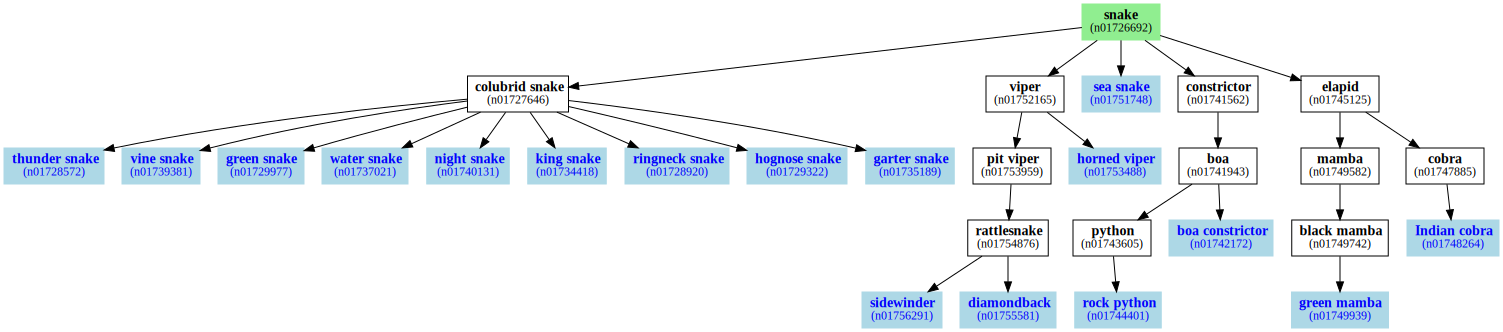

In [12]:
# Snake
g = generate_graph_from_root('n01726692', known_names=known_names)
# save_graph_svg(g,'../figures/snake_tree.svg')
g

Children of watercraft(n04530566) -- 13 descendents
	gondola (n03447447)
	schooner (n04147183)
	liner (n03673027)
	container ship (n03095699)
	trimaran (n04483307)
	speedboat (n04273569)
	fireboat (n03344393)
	pirate (n03947888)
	wreck (n04606251)
	canoe (n02951358)
	catamaran (n02981792)
	yawl (n04612504)
	lifeboat (n03662601)


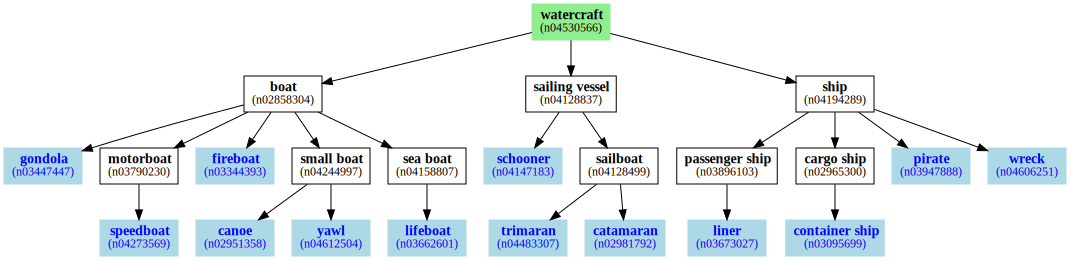

In [100]:
# Watercraft
g = generate_graph_from_root('n04530566', known_names=known_names)
save_graph_svg(g,'../figures/watercraft_tree.svg')
g

Children of bird(n01503061) -- 52 descendents
	sulphur-crested cockatoo (n01819313)
	crane (n02012849)
	goldfinch (n01531178)
	drake (n01847000)
	lorikeet (n01820546)
	house finch (n01532829)
	kite (n01608432)
	pelican (n02051845)
	jacamar (n01843065)
	red-backed sandpiper (n02027492)
	oystercatcher (n02037110)
	junco (n01534433)
	bee eater (n01828970)
	hen (n01514859)
	dowitcher (n02033041)
	African grey (n01817953)
	albatross (n02058221)
	black swan (n01860187)
	bulbul (n01560419)
	hummingbird (n01833805)
	king penguin (n02056570)
	toucan (n01843383)
	water ouzel (n01601694)
	limpkin (n02013706)
	American coot (n02018207)
	great grey owl (n01622779)
	coucal (n01824575)
	goose (n01855672)
	redshank (n02028035)
	bittern (n02011460)
	red-breasted merganser (n01855032)
	bald eagle (n01614925)
	flamingo (n02007558)
	jay (n01580077)
	magpie (n01582220)
	vulture (n01616318)
	spoonbill (n02006656)
	macaw (n01818515)
	indigo bunting (n01537544)
	ruddy turnstone (n02025239)
	black stork (n0200

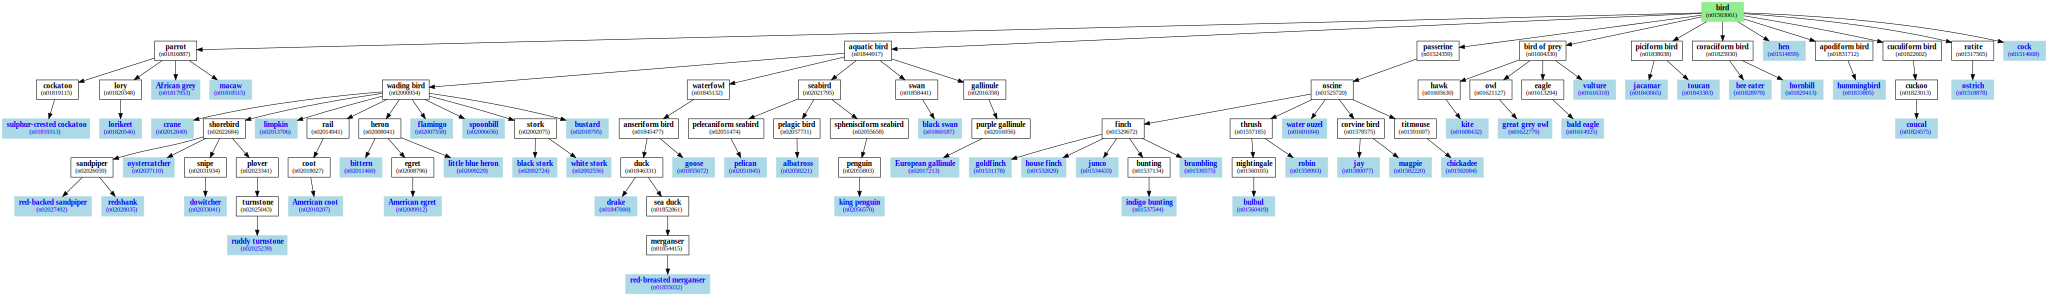

In [101]:
# Bird!
g = generate_graph_from_root('n01503061', known_names=known_names)
save_graph_svg(g,'../figures/bird_tree.svg')
g

Children of dog(n02084071) -- 116 descendents
	collie (n02106030)
	Sealyham terrier (n02095889)
	Samoyed (n02111889)
	Irish terrier (n02093991)
	bluetick (n02088632)
	bull mastiff (n02108422)
	kelpie (n02105412)
	English setter (n02100735)
	Norwich terrier (n02094258)
	Afghan hound (n02088094)
	Rottweiler (n02106550)
	Irish water spaniel (n02102973)
	black-and-tan coonhound (n02089078)
	cairn (n02096177)
	German short-haired pointer (n02100236)
	Japanese spaniel (n02085782)
	Pembroke (n02113023)
	soft-coated wheaten terrier (n02098105)
	Border terrier (n02093754)
	Saint Bernard (n02109525)
	toy terrier (n02087046)
	borzoi (n02090622)
	Ibizan hound (n02091244)
	Bernese mountain dog (n02107683)
	Gordon setter (n02101006)
	Great Dane (n02109047)
	Border collie (n02106166)
	Airedale (n02096051)
	Pekinese (n02086079)
	West Highland white terrier (n02098286)
	Scotch terrier (n02097298)
	Walker hound (n02089867)
	Shetland sheepdog (n02105855)
	Labrador retriever (n02099712)
	miniature schnauz

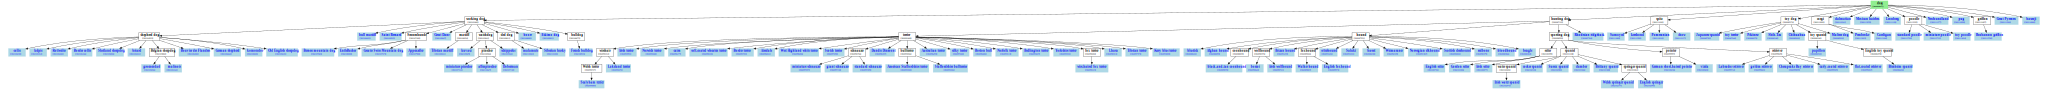

In [102]:
# Dog!
g = generate_graph_from_root('n02084071', known_names=known_names)
save_graph_svg(g,'../figures/dog_tree.svg')
g

In [121]:
det_clsloc_names(syn_data, 14, 3)

('band aid (id: 14)', 'Siberian husky (id: 3)')

In [113]:
syn_data.clsloc_synsets_id[3]

'n02110185'

In [122]:
syn_data.det_synsets['n04530566']

{'desc': 'such as ship or boat): a craft designed for water transportation',
 'id': 197,
 'name': 'watercraft',
 'wnid': 'n04530566'}

# Category Analysis

In [21]:
from tabulate import tabulate

# Figure out how many of the 1000 clsloc classes map into the 200 det ones
# and how many of the det ones are not covered in the 1000 classes (-- all are covered)
det_num_clsloc = {}
for wnid in syn_data.det_synsets_id.values(): det_num_clsloc[wnid] = 0
for wnid,parentid in syn_data.clsloc_2_det.items():
    det_num_clsloc[parentid] += 1

det_nums_list = list(det_num_clsloc.items())
det_nums_list.sort(key=lambda x: x[1])
det_nums_list = det_nums_list[::-1]
# print_wnid = lambda x: print("{} ({}) has {} categories in clsloc.".
#                              format(det_synsets[x[0]]['name'],x[0],x[1]))
table=[]
for wnid in det_nums_list[:15]:
    print("{} ({}): {}".format(syn_data.det_synsets[wnid[0]]['name'],wnid[0],wnid[1]))
    table.append(("{} ({})".format(syn_data.det_synsets[wnid[0]]['name'],wnid[0]), wnid[1]))
print("\n\n")
# for wnid in det_nums_list[-10:]:  
#     print("{} ({}) has {} categories in clsloc.".
#                              format(syn_data.det_synsets[wnid[0]]['name'],wnid[0],wnid[1]))    
print(tabulate(table,['Class', 'nc'], tablefmt="latex"))

dog (n02084071): 116
bird (n01503061): 52
snake (n01726692): 17
watercraft (n04530566): 13
monkey (n02484322): 13
lizard (n01674464): 11
car (n02958343): 10
butterfly (n02274259): 6
domestic cat (n02121808): 5
turtle (n01662784): 5
chair (n03001627): 4
bear (n02131653): 4
fox (n02118333): 4
swine (n02395003): 3
baby bed (n02766320): 3



\begin{tabular}{lr}
\hline
 Class                    &   nc \\
\hline
 dog (n02084071)          &  116 \\
 bird (n01503061)         &   52 \\
 snake (n01726692)        &   17 \\
 watercraft (n04530566)   &   13 \\
 monkey (n02484322)       &   13 \\
 lizard (n01674464)       &   11 \\
 car (n02958343)          &   10 \\
 butterfly (n02274259)    &    6 \\
 domestic cat (n02121808) &    5 \\
 turtle (n01662784)       &    5 \\
 chair (n03001627)        &    4 \\
 bear (n02131653)         &    4 \\
 fox (n02118333)          &    4 \\
 swine (n02395003)        &    3 \\
 baby bed (n02766320)     &    3 \\
\hline
\end{tabular}


# List of categories and their image count

In [16]:
table = []
cats = sorted(db.det_categories.values(), key=lambda x: x.num, reverse=True)

model_names=['inceptionv3', 'resnet50', 'vgg19', 'vgg16', 'alexnet']

for i,c in enumerate(cats[:57]):
    t1_ok = ["{} ({:.2f})".
             format(np.sum(models[mn].datasets['original'].categories[c.idx].correct_top1),
                    models[mn].datasets['original'].categories[c.idx].top1_acc(False))
            for mn in model_names]
    table.append((i+1,
                 "{} (id: {})".format(c.name, c.idx),
                 c.num, c.num_clsloc_cats,
                 "%.3f"%c.random_chance_top1, "%.3f"%c.random_chance_top5,
                  *t1_ok
                 ))
    
headers = ['','name', '#', 'nc', 'RC1', 'RC5', *model_names ]
print(tabulate(table, headers=headers, tablefmt='latex'))


\begin{tabular}{rlrrrrlllll}
\hline
    & name                       &    \# &   nc &   RC1 &   RC5 & inceptionv3   & resnet50    & vgg19       & vgg16       & alexnet     \\
\hline
  1 & bird (id: 26)              & 1629 &   52 & 0.052 & 0.235 & 1393 (0.86)   & 1275 (0.78) & 1283 (0.79) & 1257 (0.77) & 1159 (0.71) \\
  2 & dog (id: 58)               & 1365 &  116 & 0.116 & 0.461 & 1286 (0.94)   & 1230 (0.90) & 1198 (0.88) & 1198 (0.88) & 906 (0.66)  \\
  3 & person (id: 124)           &  371 &    3 & 0.003 & 0.015 & 25 (0.07)     & 26 (0.07)   & 15 (0.04)   & 12 (0.03)   & 21 (0.06)   \\
  4 & snake (id: 159)            &  353 &   17 & 0.017 & 0.082 & 292 (0.83)    & 237 (0.67)  & 249 (0.71)  & 228 (0.65)  & 184 (0.52)  \\
  5 & lizard (id: 105)           &  246 &   11 & 0.011 & 0.054 & 192 (0.78)    & 169 (0.69)  & 179 (0.73)  & 167 (0.68)  & 79 (0.32)   \\
  6 & monkey (id: 113)           &  229 &   13 & 0.013 & 0.063 & 190 (0.83)    & 147 (0.64)  & 144 (0.63)  & 145 (0.63)  & 110 (

In [23]:
cats

[DetCategory(idx=26, wnid='n01503061', name='bird', num_clsloc_cats=52, random_chance_top1=0.051999999999999998, random_chance_top5=0.23475107303260959, num=1629),
 DetCategory(idx=58, wnid='n02084071', name='dog', num_clsloc_cats=116, random_chance_top1=0.11600000000000001, random_chance_top5=0.46087483007728058, num=1365),
 DetCategory(idx=124, wnid='n00007846', name='person', num_clsloc_cats=3, random_chance_top1=0.0030000000000000001, random_chance_top5=0.014940000120360841, num=371),
 DetCategory(idx=159, wnid='n01726692', name='snake', num_clsloc_cats=17, random_chance_top1=0.017000000000000001, random_chance_top5=0.082317913392758887, num=353),
 DetCategory(idx=105, wnid='n01674464', name='lizard', num_clsloc_cats=11, random_chance_top1=0.010999999999999999, random_chance_top5=0.053908788885752151, num=246),
 DetCategory(idx=113, wnid='n02484322', name='monkey', num_clsloc_cats=13, random_chance_top1=0.012999999999999999, random_chance_top5=0.063455563877858112, num=229),
 DetCa

In [33]:
np.sum(models['inceptionv3'].datasets['original'].categories[2].correct_top1)

30

In [29]:
models['inceptionv3'].datasets['original'].categories[1].correct_top1

TypeError: 'numpy.ndarray' object is not callable